In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import trieste
import gpflow
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import math
from util import plotting

2021-11-30 14:24:20.760706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 14:24:20.760723: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-30 14:24:21.968093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 14:24:21.968698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 14:24:21.968763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [3]:
from trieste.objectives.multi_objectives import VLMOP2
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.data import Dataset
from trieste.models.gpflow.models import GPRStack
from trieste.models.gpflow.models import GaussianProcessRegression

from trieste.acquisition import BatchMonteCarloExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer

In [4]:
from trieste.acquisition.multi_objective.pareto import Pareto, get_reference_point

In [5]:
search_space = trieste.space.Box([0], [2*math.pi])

def f1(x):
    return tf.cos(2 * x) + tf.sin(x)

def f2(x):
    return 0.2 * (tf.cos(x) - tf.sin(x)) + 0.3

def f(x):
    return tf.concat([f1(x), f2(x)], axis=-1)

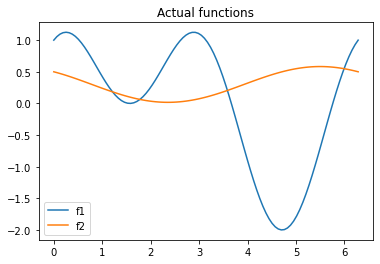

In [6]:
x_plot = np.linspace(start=search_space.lower[0], stop=search_space.upper[0], num=100)

plt.plot(x_plot, f1(x_plot), label="f1");
plt.plot(x_plot, f2(x_plot), label="f2");
plt.legend();
plt.title("Actual functions");
plt.show();

In [7]:
def build_stacked_independent_objectives_model(data: Dataset):
    gprs = []
    for idx in range(2):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        variance = tf.math.reduce_variance(single_obj_data.observations)
        kernel = gpflow.kernels.Matern52(variance, tf.constant(0.2, tf.float64))
        gpr = gpflow.models.GPR(single_obj_data.astuple(), kernel, noise_variance=1e-5)
        gpflow.utilities.set_trainable(gpr.likelihood, False)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return GPRStack(*gprs)

In [8]:
observer = mk_observer(f, OBJECTIVE)

In [9]:
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

In [10]:
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

2021-11-30 14:24:22.366696: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
num_steps = 3
num_query_points=4

acq_function = BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)

In [12]:
result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)
dataset = result.try_get_final_datasets()[OBJECTIVE]

2021-11-30 14:24:23.411549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-30 14:24:26.773613: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-11-30 14:24:29.764539: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-11-30 14:24:31.090298: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 960000000 exceeds 10% of free system memory.
2021-11-30 14:24:31.301379: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 960000000 exceeds 10% of free system memory.
2021-11-30 14:24:31.441967: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 960000000 exceeds 10% of free system memory.
2

Optimization completed without errors


In [13]:
models = result.try_get_final_models()[OBJECTIVE]._models

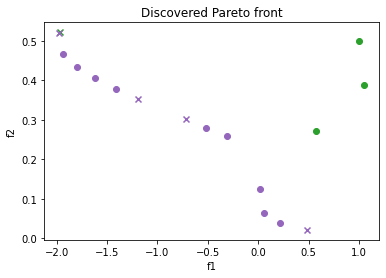

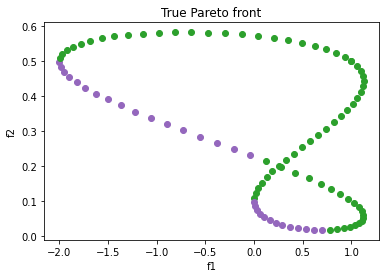

In [14]:
all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.stack([f1(x_plot), f2(x_plot)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();

In [15]:
from trieste.acquisition.function.local_penalization import MOLocalPenalizationAcquisitionFunction

In [16]:
acq_function = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

------------------------------------
[[0]]
[[0.36709128554919218]]
[[0.75]]
[[0.27531846416189415]]
------------------------------------


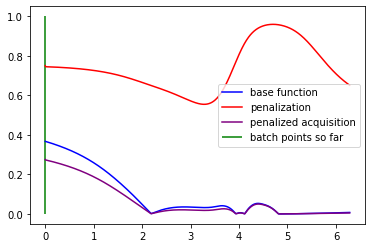

------------------------------------
[[0]
 [0]]
[[0.36709128554919218]
 [0.36709128554919218]]
[[0.5625]
 [0.5625]]
[[0.2064888481214206]
 [0.2064888481214206]]
------------------------------------


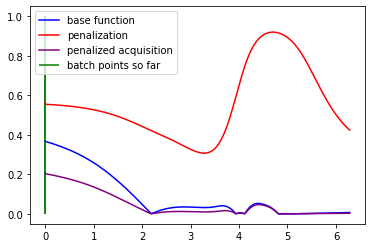

------------------------------------
[[0]
 [0]
 [0]]
[[0.36709128554919218]
 [0.36709128554919218]
 [0.36709128554919218]]
[[0.421875]
 [0.421875]
 [0.421875]]
[[0.15486663609106543]
 [0.15486663609106543]
 [0.15486663609106543]]
------------------------------------


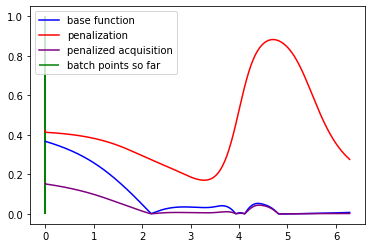

------------------------------------
[[4.39055807807461]]
[[0.052885209964838989]]
[[0.75]]
[[0.039663907473629252]]
------------------------------------


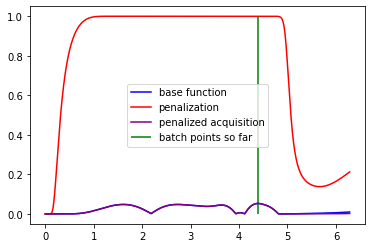

------------------------------------
[[4.39055807807461]
 [4.3906275457968151]]
[[0.05288520996483901]
 [0.052885207198233836]]
[[0.75]
 [0.74999999999214673]]
[[0.039663907473629266]
 [0.039663905398260056]]
------------------------------------


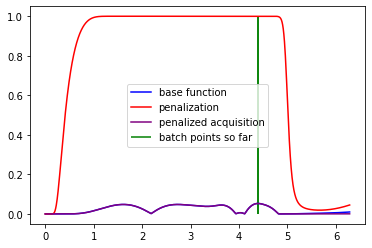

------------------------------------
[[4.39055807807461]
 [4.3906275457968151]
 [4.3906338826336819]]
[[0.05288520996483901]
 [0.052885207198233836]
 [0.052885206685907467]]
[[0.75]
 [0.70786268539805242]
 [0.7499999999849164]]
[[0.039663907473629266]
 [0.037435464785174212]
 [0.039663905013632907]]
------------------------------------


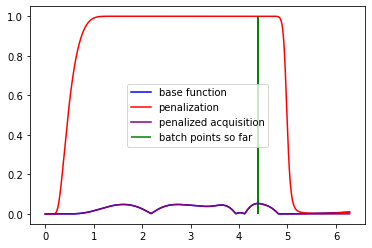

Optimization completed without errors


In [30]:
result = BayesianOptimizer(observer, search_space).optimize(2, initial_data, {OBJECTIVE: model}, acq_rule)
dataset = result.try_get_final_datasets()[OBJECTIVE]

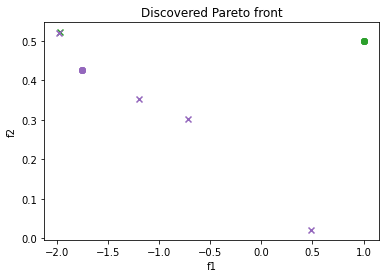

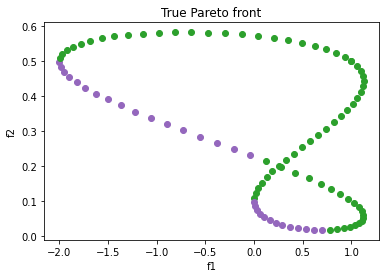

In [31]:
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.stack([f1(x_plot), f2(x_plot)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();